# Στοιχεία ομάδας
# Ομάδα Β3
# Μπάκος Παναγιώτης ( 03113014 )
# Φώτος Νικόλαος ( 03113122 )

---

# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. Σύστημα συστάσεων βασισμένο στο περιεχόμενο - σημασιολογική απεικόνιση δεδομένων με χρήση SOM 

In [1]:
# Απαραίτητα Imports
from io import StringIO
import requests
import json
import pandas as pd
import numpy as np
!pip install unidecode
from unidecode import unidecode
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import random
from sklearn.externals import joblib
!pip install somoclu
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline
from sklearn.cluster import KMeans

## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με περίπου 40.000 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset στο dataframe `df_data_1`: 

In [2]:
# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_object_storage_file_with_credentials_38ba68786cf84e1cbb5cc80f5a49fbed(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': 'member_e83bb2ed70e300a3a681580fec6a7d42c6cd8eb2','domain': {'id': 'dd180082cfbb4aba93677ea2bbc9d7ff'},
            'password': 'y]333V2!.D=?Blh='}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)

# Your data file was loaded into a StringIO object and you can process the data.
# Please read the documentation of pandas to learn more about your possibilities to load your data.
# pandas documentation: http://pandas.pydata.org/pandas-docs/stable/io.html
df_data_1 = pd.read_csv(get_object_storage_file_with_credentials_38ba68786cf84e1cbb5cc80f5a49fbed('DefaultProjectankynotpankygmailcom', 'movieDBe.csv'), sep='\t',  header=None, quoting=3)
df_data_2 = pd.read_csv(get_object_storage_file_with_credentials_38ba68786cf84e1cbb5cc80f5a49fbed('DefaultProjectankynotpankygmailcom', 'seedb.csv'),  header=None)

Το data frame `df_data_2` έχει 100 γραμμές και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της [εδώ](https://goo.gl/4TuDcA).

In [3]:
team_seed_number = 39
my_index = df_data_2.iloc[team_seed_number,:].values
titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(np.float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries

In [4]:
print '\n\n','Title : ',titles[197][0]
print '\n\n','Categories : ',categories[197][0]
print '\n\n',catbins[197]      
print '\n\n','Summary\n',summaries[197]
print '\n\n','Corpus\n',corpus[197]



Title :  Pojkarna på Storholmen


Categories :  "Comedy",  "Black-and-white"


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=100` θα γράψουμε `print corpus[100]`.

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="50%">

Η πρώτη εφαρμογή που θα αναπτύξουμε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξουμε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus).

---

Αρχικά θα πρέπει να γίνει η προεπεξεργασία των κειμένων της λίστας corpus


# Preprocessing

Αρχικά χρειάζεται να αφαιρέσουμε οποιουσδήποτε non-unicode characters, προκειμένου να μην δημιουργηθούν αργότερα προβλήματα κατά το Stemming & Lemmatization

In [5]:
def remove_non_ascii(text):
    return unidecode(unicode(text, encoding = "utf-8"))

In [6]:
print titles[197]
print 'Original: '+corpus[197][0:58]+'...'

corpus_edited = []
for curr in corpus:
    corpus_edited.append(remove_non_ascii(curr))

print 'Edited  : '+corpus_edited[197][0:57]+'...'

['Pojkarna p\xc3\xa5 Storholmen']
Original: The Sjölund family at Lillholmen Island in the Stockholm ...
Edited  : The Sjolund family at Lillholmen Island in the Stockholm ...


## Επεξεργασία string
Τώρα που φορτώσαμε το κείμενο στην python, πρέπει να το επεξεργαστούμε. Επειδή ο υπολογιστής θεωρεί τα κεφαλαία και τα μικρά ως διαφορετικούς χαρακτήρες, το πρώτο πράγμα που πρέπει να κάνουμε είναι να τα κάνουμε όλα μικρά. Αν και η συγκεκριμένη διαδικασία θα γινόταν και από τον `TfidfVectorizer` αργότερα, την παρουσιάζουμε για λόγους πληρότητας. Έπειτα θέλουμε να χωρίσουμε τις λέξεις μια προς μια, ώστε να φτιάξουμε μια λίστα τα στοιχεία της οποίας θα είναι οι λέξεις. H διεργασία αυτή θα γίνει για κάθε περιγραφή ταινίας ξεχωριστά (ανά corpus[i])

In [7]:
words = []
for i in range(0,len(corpus_edited),1):
    corpus_edited[i] = corpus_edited[i].lower()
    words.append(nltk.word_tokenize(corpus_edited[i]))
    
print 'Edited  : '+corpus_edited[197][0:59]+'...'
print str(words[197][0:9])+ ' ...'

Edited  : the sjolund family at lillholmen island in the stockholm ar...
['the', 'sjolund', 'family', 'at', 'lillholmen', 'island', 'in', 'the', 'stockholm'] ...


Το tokenizer ουσιαστικά κάνει ό,τι και η built-in μέθοδος `.split()` των string, αλλά λίγο πιο έξυπνα. Για αρχή χωρίζει με βάση τόσο τα κενά (' '), όσο και τα tabs ('\t') και τα new lines ('\n'). Επίσης  χωρίζει και τις παρενθέσεις από το περιεχόμενό τους.

Το επόμενο βήμα είναι να διαγράψουμε από τη λίστα μας τα σημεία στίξης. Μόλις το κάνουμε αυτό, θέλουμε να διαγράψουμε και μερικές συχνά χρησιμοποιούμενες λέξεις που δεν προσφέρουν σημασιολογική αξία στο κείμενο (stopwords).

In [8]:
nltk.download('stopwords') # κατεβάζουμε ένα αρχείο που έχει stopwords στα αγγλικά

filtered_words = []
for i in range(0,len(words),1):
    filtered_words.append([word for word in words[i] if word not in stopwords.words('english') + list(string.punctuation)])

[nltk_data] Downloading package stopwords to /gpfs/fs01/user/s440-f39b
[nltk_data]     d962225440-fe8dadcb5f83/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Πρέπει να κάνουμε καλύτερη δουλειά στην αφαίρεση των σημείων στίξης γιατί δεν αφαιρούνται οι λέξεις που περιέχουν περισσότερα από ένα τέτοια σημεία.

In [9]:
def thorough_filter_upgraded(words):
    filtered_words = []
    for word in words:
        pun = []
        for letter in word:
            pun.append(any(ext in letter for ext in string.punctuation))
        filt=[]
        for i in range(0,len(word),1):
            if not pun[i]:
                filt.append(word[i])
        filtered_words.append(filt)
    return filtered_words
        
new_filtered_words = thorough_filter_upgraded(filtered_words)

Ενδεικτικά ακολουθεί ένα κομμάτι του συγκεκριμένου corpus που δείχνει ότι αφαιρέσαμε σωστά τα puncuation points 

! " # $ % & ' ( ) * + , - . / : ; < = > ? @ [ \ ] ^ _ ` { | } ~

In [10]:
print 'Original:\n ... '+str(filtered_words[197][5:20]) + ' ...'
print 'Edited:\n ... '+str(new_filtered_words[197][5:18]) + ' ...'

Original:
 ... ['archipelago', 'quite', 'religious', 'therefore', 'regarded', 'suitable', 'place', 'care', '``', 'odd', 'young', 'people', 'adrift', "''", 'placed'] ...
Edited:
 ... ['archipelago', 'quite', 'religious', 'therefore', 'regarded', 'suitable', 'place', 'care', 'odd', 'young', 'people', 'adrift', 'placed'] ...


## Stemming & Lemmatization
Για γραμματικούς λόγους, τα κείμενα χρησιμοποιούν διαφορετικές μορφές μιας λέξης, όπως π.χ. play, plays, playing, played. Αυτό έχει σαν αποτέλεσμα πως, ενώ αναφερόμαστε στην ίδια λέξη, ο υπολογιστής τις καταλαβαίνει ως διαφορετικές. Για να λύσουμε αυτό το πρόβλημα, μπορούμε να χρησιμοποιήσουμε δύο γλωσσολογικούς μετασχηματισμούς, είτε την αφαίρεση της κατάληξης (stemming), είτε τη λημματοποίηση (lemmatization). Ο στόχος, τόσο της αφαίρεσης κατάληξης όσο και της λημματοποίησης, είναι να φέρουν τις διάφορες μορφές της λέξης σε μια κοινή μορφή βάσης. Πιο συγκεκριμένα:

Η αφαίρεση της κατάληξης αναφέρεται σε μια ακατέργαστη ευριστική διαδικασία που απομακρύνει τα άκρα των λέξεων με την ελπίδα να επιτύχει αυτό το στόχο σωστά τις περισσότερες φορές.

Η λημματοποίηση αναφέρεται στην απομάκρυνση της κλίσης των λέξεων και στην επιστροφή της μορφής της λέξης όπως θα τη βρίσκαμε στο λεξικό, με τη χρήση λεξιλογίου και μορφολογικής ανάλυσης των λέξεων. Η μορφή αυτή είναι γνωστή ως λήμμα (lemma).

In [11]:
nltk.download('wordnet') # απαραίτητα download για τους stemmer/lemmatizer
nltk.download('rslp')

wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer = PorterStemmer()

lem_words = []
stem_words = []
for curr in range(0,len(new_filtered_words),1):
    lem_words.append([wordnet_lemmatizer.lemmatize(word) for word in new_filtered_words[curr]])
    stem_words.append([porter_stemmer.stem(word) for word in new_filtered_words[curr]])

print '\n{:<20} {:<20} {:<20}'.format('Original', 'Stemmed', 'Lemmatized')
print '-'*60
print '{:<20} {:<20} {:<20}'.format('...', '...', '...')
for i in range(5,20,1):
    print '{:<20} {:<20} {:<20}'.format(new_filtered_words[197][i], stem_words[197][i], lem_words[197][i])
print '{:<20} {:<20} {:<20}'.format('...', '...', '...')


[nltk_data] Downloading package wordnet to /gpfs/fs01/user/s440-f39bd9
[nltk_data]     62225440-fe8dadcb5f83/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package rslp to /gpfs/fs01/user/s440-f39bd9622
[nltk_data]     25440-fe8dadcb5f83/nltk_data...
[nltk_data]   Package rslp is already up-to-date!

Original             Stemmed              Lemmatized          
------------------------------------------------------------
...                  ...                  ...                 
archipelago          archipelago          archipelago         
quite                quit                 quite               
religious            religi               religious           
therefore            therefor             therefore           
regarded             regard               regarded            
suitable             suitabl              suitable            
place                place                place               
care                 care  

Τώρα θα δημιουργήσουμε τα τελικά κείμενα που θα αποτελούν την νέα περιγραφή κάθε ταινίας. Επιλέγουμε την έξοδο του Stemmer και όχι του Lemmatizer να δώσει τις νέες περιγραφές των ταινιών μας.

Με τον ακόλουθο κώδικα φέρνουμε τις περιγραφές των ταινιών σε μορφή όμοια με την αρχική. Ενδεικτικά παρουσιάζουμε το description της ταινίας που μας έχει απασχολήσει μέχρι στιγμής. Παρατηρούμε ότι με το preprocessing έχει μειωθεί αρκετά το μέγεθος κάθε κειμένου, καθώς έχουμε ξεφορτωθεί κάθε άχρηστη πληροφορία, επιτρέποντας στο σύστημα αργότερα να εστιάσει στις "σημαντικές" λεπτομέρειες. 

In [12]:
corpus_final = []
for i in range (0,len(stem_words),1):
    corpus_final.append(' '.join(stem_words[i]))

print corpus[197]+'\n'
print corpus_final[197]

The Sjölund family at Lillholmen Island in the Stockholm archipelago is quite religious and has therefore been regarded as a suitable place for the care of "odd young people adrift" who are to be placed there by the "Municipal Protection Society for Young Girls". One day, the fashionable Sonja Waller, a woman with a "questionable reputation", is expected at the island and the Sjölunds are waiting anxiously. Unfortunately, the young handsome Gunnar Andersson of the neighboring Storholmen Island has been sent to get her at a local steamboat bridge. Sonja, who is a pretty girl, immediately makes a great impression on Gunnar, who soon forgets that he is actually engaged to Aina, Sjölund's daughter. As Gunnar wants to show off for the new guest, the boat trip back to the Lillholmen is delayed for more than an hour. Back at the Storholmen Island, the general mood gets tense as all the locals are anxious to have a glimpse of the woman from the big city. After a short while, Ivar  and Sixten ,

Αφότου έχουμε ολοκληρώσει τις γλωσσολογικές προεπεξεργασίες, μπορούμε να προχωρήσουμε στο πρόβλημα της ομαδοποίησης των κειμένων. Πιο συγκεκριμένα θέλουμε να δούμε ποιοι όροι (λέξεις) είναι πιο σημαντικοί για κάθε ομάδα. Πρώτο βήμα όμως είναι η αναπαράσταση των προτάσεων σε διανύσματα.

# TF-IDF
Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται αρχικά δεν είναι βελτιστοποιημένη. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν δραματική επίδραση στην ποιότητα των συστάσεων και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη διαστατικότητα των δεδομένων. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους χρόνους εκπαίδευσης, ιδιαίτερα στη δεύτερη εφαρμογή.

Επιλέξαμε να πειραματιστούμε με τις ακόλουθες παραμέτρους :
    
1. stop_words : Αν και είχαν αφαιρεθεί ήδη οι περισσότερες stop words χειροκίνητα, παρατηρούμε ότι πέφτει κι άλλο η διαστατικότητα εάν αξιοποιήσουμε την αφαίρεση των stop words από τον TfidfVectorizer 
2. min_df : Αγνοεί τους όρους που έχουν μικρότερη συχνότητα εμφάνισης από το ορισμένο "κατώφλι". Οι συγκεκριμένοι όροι θεωρούνται ασήμαντοι επομένως η αφαιρεσή τους δεν θα επηρεάσει την ακρίβεια του recommender system

Για διαφορετικά configurations του `TfidfVectorizer` λαμβάνουμε δεδομένα με τις εξής διαστάσεις. Επιλέγουμε το τελευταίο, καθώς κρατάει τις ελάχιστες παραμέτρους που θα χρειαστούν για τη δημιουργία του recommender και κάνει το σύστημα πιο εύρωστο. Για τις διάφορες τιμές του `min_df` που δοκιμάσαμε, παρατηρήσαμε ότι στις περισσότερες ταινίες οι πρώτες 6-7 προτάσεις ήταν ίδιες (με διαφορετική ίσως σειρά επομένως επιλέξαμε να κρατήσουμε το configuration που δίνει μικρότερης διάστασης `corpus_tfidf`. Επιλέξαμε δηλαδή `min_df=4`, δηλαδή να 'κόβονται' οι λέξεις που εμφανίζονται κάτω από 4 φορές σε ένα κείμενο. Όσες απομένουν αρκούν για να προτείνει το recommender system μια κοντινή ταινία. Συνοπτικά, αυτά είναι τα configurations που δοκιμάσαμε μέχρι να επιλέξουμε το κατά τη γνώμη μας καλύτερο

    ________________________________________________________________
    |                                           |                  |
    |TF-IDF Vectorizer Configuration            | Corpus_tfidf size|
    |-------------------------------------------|------------------|
    |default                                    | (5000, 33733)    |
    |stop_words='english'                       | (5000, 33587)    |
    |stop_words='english', min_df=2             | (5000, 16227)    |
    |stop_words='english', min_df=3             | (5000, 12286)    |
    |stop_words='english', min_df=4             | (5000, 10303)    |
    |___________________________________________|__________________|

In [13]:
vectorizer = TfidfVectorizer(stop_words='english',min_df=4)
corpus_tf_idf = vectorizer.fit_transform(corpus_final)
print corpus_tf_idf.shape

(5000, 10303)


Το σύστημα συστάσεων που θα παραδώσουμε θα είναι μια συνάρτηση `content_recommender` με δύο ορίσματα `target_movie` και `max_recommendations`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιούμε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, από το `corpus_tf_idf` υπολογίζουμε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής μας
- με βάση την ομοιότητα συνημιτόνου που υπολογίσαμε, δημιουργήσαμε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώνουμε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), id, τίτλο, σύνοψη, κατηγορίες (categories)

In [14]:
def content_recommender(target_movie, max_recommendations):
    print '{:<5} {:<10} {:<50} {:<20}'.format('     ','['+str(target_movie)+']',titles[target_movie], categories[target_movie])
    print(summaries[target_movie])
    print('\n')

    similarity = cosine_similarity(corpus_tf_idf[target_movie,:], corpus_tf_idf)
    #print(similarity.shape)

    # set cos similarity with self from 1->0 because we do not want the recommender system to recommend the same film!
    similarity[0,target_movie] = 0 # or we could just later emit the first element of sorted array..nevermind

    indices = similarity.argsort().transpose() #sort by values of similarity array, and keep indices of each element
    #sort was done in ascending way, keep last max_recommendations elements of indices array only and reverse list
    indices = reversed(indices[-max_recommendations:]) 

    cnt=1
    print 'For this movie I recommend you the following!'
    for i in indices:
        #print similarity[0,i]
        print '\n{:<5} {:<10} {:<50} {:<20}'.format(str(cnt)+')', str(i), titles[i,0], categories[i,0])
        cnt = cnt+1
        print summaries[i,0]

Ας δούμε για 10 τυχαίες ταινίες που θα επιλεχθούν από το Dataset μας τι θα προτείνει το σύστημα που υλοποιήσαμε

In [15]:
movies_to_check = random.sample(range(0, 4999), 10)

max_recommendations = 5
for target_movie in movies_to_check:
    content_recommender(target_movie,max_recommendations)
    print'\n\n','-'*105,'\n\n'


      [3637]     ['The Big Red One']                                ['"Combat Films",  "Action",  "Drama",  "War film"']
[ 'The film begins in black and white at the end of World War I. A Private , using his trench knife, kills a German soldier who was approaching with his arms raised and muttering in German. In the background stands a wooden crucifix, the wood infested with termites. When he returns to his company\'s headquarters, the private is told that the war ended "about four hours ago." The 1st Division patch is shown in color. The film then transitions to a Sergeant  as he leads his squad of infantrymen through North Africa, Sicily, and then on to Omaha Beach at the start of the Battle of Normandy. The squad crosses the same field where the sergeant killed the surrendering German decades before, where a memorial now stands. The following short conversation takes place: :Johnson: Would you look at how fast they put the names of all our guys who got killed? :The Sergeant: That\'s

For this movie I recommend you the following!

1)    [3164]     ['The Rookie']                                     [ '"Sports",  "Family Film",  "Family Drama",  "Drama",  "Airplanes and airports"']
[ 'The film tells the story of Jim Morris, the son of a career Navy man, who moves the family to a small Texas town. Jim is shown to be a very skilled pitcher as a youth, though his father disapproves of Jim\'s dream of making it to Major League Baseball. It is later mentioned that the town to which Jim\'s family moved, Big Lake, has never cared for baseball. Thus, he was unable to play baseball in high school. He later gets a chance when he is drafted by the Milwaukee Brewers, but he tears up his shoulder, ending his hopes of achieving his lifelong dream. Years later in 1999 Morris, married with three children, is a high school science teacher, as well as head baseball coach. His team, the Big Lake Owls, is very unsuccessful with many of his players skilled, but unmotivated, especially wit

[ ' Snow White\'s mother died in child birth, and her father, the King , marries Clementianna , the most beautiful woman in the land and raises Snow White. One day, the king leaves to fight a great evil that has invaded the land but never returns. He leaves Snow White a golden dagger as a parting gift. Queen Clementianna rules in his absence and deciding that "snow must do what snow does best, snow must fall," she locks her in the palace. Ten years later Snow White  has just turned eighteen and while Queen Clementianna does not care for her, the palace staff loves her, especially the baker Margaret . Margaret tells Snow White that the kingdom is rightfully hers and that she should go outside and see what has become of her people. Snow White then defies the Queen\'s orders and leaves the palace, intent on seeing the conditions of her kingdom. In the forest, she meets Prince Andrew Alcott  and his companion Charles Renbock  who have been robbed by thieving dwarfs. She and the Prince are 

Παρατηρούμε από τις κατηγορίες κάθε `target_movie` και των προτάσεων που προκύπτουν ότι όντως το σύστημα κάνει καλές προτάσεις. Μελετώντας τα summaries των ταινιών βλέπουμε ότι δικαιολογείται κάθε πρόταση, καθώς περιλαμβάνουν 'κοντινές' (σύμφωνα με το cosine similarity) λέξεις. Θεωρούμε επομένως ότι δημιουργήσαμε ένα εύρωστο recommender system, πετυχαίνοντας μάλιστα και μείωση της διαστατικότητας των δεδομένων που χρειάστηκαν, με κατάλληλα tweaks στην `TfidfVectorizer`.

Συγκεκριμένα η θεματική που ενώνει τις target movies με τις προτάσεις καθεμίας είναι η εξής :
    
    1 ) Combar Anti-war film 
    2 ) Short film - Family film
    3 ) Action - Drama
    4 ) Horror film 
    5 ) Black and white - Drama 
    6 ) Drama - Indian movie
    7 ) Romantic comedy
    8 ) Family film - Drama
    9 ) Animation
    10) Japanese movie - Action

In [16]:
# Αποθήκευση του corpus_tf_idf
joblib.dump(corpus_tf_idf, 'corpus_tf_idf.pkl') 

---

---

---

# Εφαρμογή 2.  Σημασιολογική απεικόνιση της συλλογής ταινιών με χρήση SOM
<img src="http://visual-memory.co.uk/daniel/Documents/intgenre/Images/film-genres.jpg" width="35%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους. Η `build_final_set` αρχικά μετατρέπει την αραιή αναπαράσταση tf-idf της εξόδου της `TfidfVectorizer()` σε πυκνή (η [αραιή αναπαράσταση](https://en.wikipedia.org/wiki/Sparse_matrix) έχει τιμές μόνο για τα μη μηδενικά στοιχεία). Στη συνέχεια ενώνει την πυκνή `dense_tf_idf` αναπαράσταση και τις binarized κατηγορίες `catbins` ως επιπλέον στήλες (χαρακτηριστικά). Τέλος, δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM.

In [17]:
def build_final_set(doc_limit):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = corpus_tf_idf.toarray()[0:doc_limit,:]
    final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    return final_set

In [18]:
final_set = build_final_set(5000)
print final_set.shape

(5000, 10625)


## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Πρόκειται για μια σύγχρονη και βελτιστοποιημένη υλοποίηση των SOM, παραλληλοποιημένη για CPU και GPU.

Καταρχάς διαβάσαμε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσουμε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήσαμε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιούμε την `time` για να έχουμε μια εικόνα των χρόνων εκπαίδευσης.

Καταλήξαμε η εκπαίδευση να γίνει για χάρτη `30x30` και training για `epochs=100`

In [19]:
n_rows, n_columns = 30, 30
som = somoclu.Somoclu(n_columns, n_rows)
%time som.train(data=final_set, epochs=100)

CPU times: user 5h 21min 55s, sys: 1min 33s, total: 5h 23min 29s
Wall time: 10min 38s


## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύσαμε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύσαμε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.

In [20]:
surface_state = som.get_surface_state()
bmus = som.get_bmus(surface_state)
bmus_unique = np.unique(bmus,axis=0,return_index=True, return_counts=True)

## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.

## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώνουμε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώσαμε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκουμε εύκολα τα μεγάλα και μικρά clusters. 



## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.


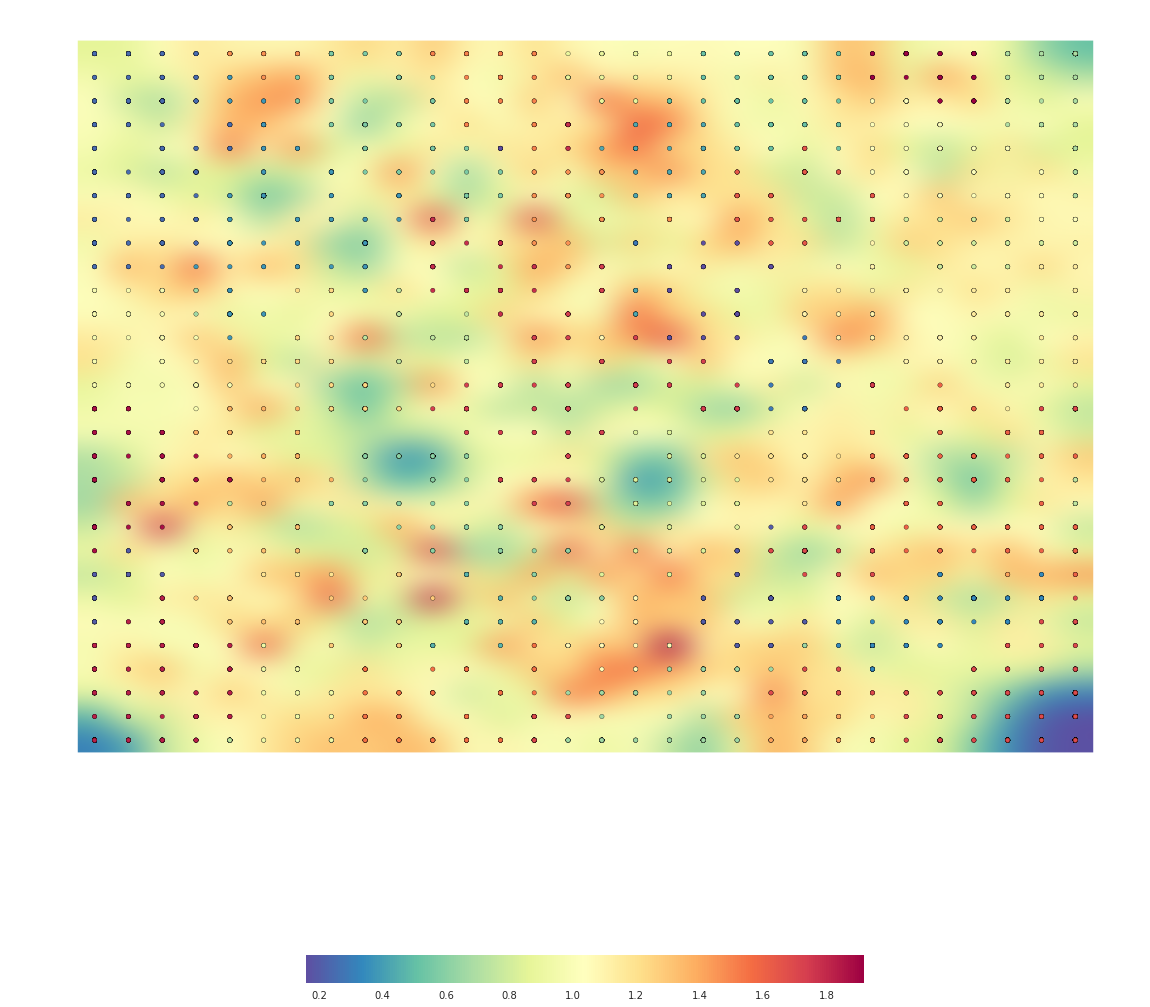

<module 'matplotlib.pyplot' from '/usr/local/src/bluemix_jupyter_bundle.v76/notebook/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [21]:
n_clusters = 40

algorithm = KMeans(n_clusters=n_clusters)
som.cluster(algorithm=algorithm)

som.view_umatrix(bestmatches=True,figsize=(20, 20),colorbar=True)

In [23]:
clusters = som.clusters # Δεν τυπωνω τον πινακα clusters, αλλα θα τον γραψω οπως προεκυψε απο κατω σε μορφη markdown για να φαινεται καλυτερο

clusters_sorted = np.unique(clusters, return_index = True, return_counts = True)
print 'Clusters sorted byincreasing number of neurons:\n',clusters_sorted[0]
print 'Cluster Starting Index:\n',clusters_sorted[1]
print 'Number Of Neurons Per Cluster:\n',clusters_sorted[2]

Clusters sorted byincreasing number of neurons:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Cluster Starting Index:
[132 620   0 256 592  34 106 671  18   7 489 303  27 309 234 496  14 755
 300  83 375 263 298 500 306 669 575 454 687   4  10 763 445 141 478 285
  74 692 450  23]
Number Of Neurons Per Cluster:
[19 22 42 13 23 40 15 10 23 32 41 25 17 17 13 26 10 14 20 23 12 21 23 13 21
 12 22 13  9 21 14 22 43 19 53 58 18 28 23 10]


# Πίνακας των Clusters     

    [ 2  2  2  2 29 29 29  9  9  9 30 30 30 30 16 16 16 16  8  8  8  8  8 39 39 39 39 12 12 12]
    [ 2  2  2  2  5 29  9  9  9  9  9 30 30 30 16 16 16 16  8  8  8  8  8 39 39 39 39 12 12 12]
    [ 2  2  2  2  5  5  9  9  9  9  9 30 30 30 36 16 16  8  8  8  8  8  8 19 19 39 39 12 12 12]
    [ 2  2  2  2  2  5  5  9  9  9  9 30 30 30 36 36  6  6  6  8  8  8  8 19 19 19 12 12 12 12]
    [ 2  2  2  2  2  5  5  9  9  9  9  9  0 30 36  6  6  6  6  8  8 33  8 19 19 19 19 19 12 12]
    [ 2  2  2  2  2  5  5  5  9  9  9  9  9 29 29 29  6  6  6 33 33 33 33 19 19 19 19 19 19 12]
    [ 2  2  2  2  5  5  5  5  5  5  9  9  9 29 29 29  6  6  6 33 33 33 33 33 19 19 19 19 19 12]
    [ 2  2  2  2  5  5  5  5  5  5 36  9  9 29 29 29 29 29 29 33 33 33 33 33 14 14 14 14 19 19]
    [ 2  2  2  2  5  5  5  5  5  5 36 36 36 29 29 29  3  0  0  0 33 33 33 21 14 14 14 14 14 14]
    [ 2  2  2  5  5  5  5  5  5 36 36 36 36 36 29 35 29  0  0  0  0 33 21 21 21 14 14 14 22 22]
    [18 18 18 11  5  5 24 24  5 13 36 36 36 36 35 35  6  0  0  0  0 21 21 21 21 21 22 22 22 22]
    [18 18 18 11  5  5 24 24 13 13 13 13 36 35 35 35  6  0  0  0  0 21 21 21 21 21 22 22 22 22]
    [18 18 18 18  5 24 24 24 13 13 13 13 13 35 35 20 35  0  0  0  3  3 21 21 21 21 22 22 22 22]
    [18 18 18 18 24 24 24 24 24 13 13 13 35 35 35 35 35 35 35  3  3  3  3 21 21 21 22 22 22 22]
    [18 18 18 18 18 24 24 24 24 24 24 35 35 35 35 35 35 35 35 35  3  3  3 35 35 32 22 22 22 22]
    [38 38 38 18 27 27 27 24 24 24 35 35 35 35 35 35 35 35 35 35  3  3  3 35 32 32 32 22 34 34]
    [38 38 38 27 27 27 27 35 35 10 10 35 35 35 35 35 15 15 35 35 23 23 35 32 32 32 32 32 32 34]
    [38 38 38 38 27 27 27 10 10 10 10 10 35 35 35 35 15 15 15 23 23 23 23 32 32 32 32 32 32 32]
    [38 38 38 38 38 27 27 27 10 10 10 10 35 35 35 15 15 15 15 15 23 23 23 32 32 32 32 32 32 13]
    [38 38 38 38 13 26 26 10 10 10 10 10 10 35 35 15 15 15 15 15 34 23  4 32 32 32 32 32 32 13]
    [38 38 38 26 26 26 26 26 10 10 10 10 10 10 10 15 15 15 15 15  1 34 34 32 32 32 32 32 32 32]
    [38  1 26 26 26 26 26 26 10 10 10 10 10 10 10 10 15 15 15  1 34 34 34 34 32 32 32 32 32 32]
    [ 1  1  1 26 26 23 23 23 10 25 10  7 10 10 10 15 15 15  1  1  1 34 34 34  4  4  4 28  4 32]
    [ 1  1 37 26 26 26 26 25 25 25 25  7  7 10 10 10 20 35  1  1  1  1  4  4  4  4  4  4  4 34]
    [ 1 37 37 37 26 26 26 25 25 25  7  7  7  7 10 20 20 20  1  1  1  1  4  4  4  4  4  4 34 34]
    [37 37 37 37 37 17 17 25 25 25  7  7  7 31 20 20 20 20 11  1  1 11  4  4  4  4 34 34 34 34]
    [37 37 37 37 37 17 17 17 31 25 31 31 31 31 20 20 20 11 11 11 11 34 34  4 34 34 34 34 34 34]
    [37 37 37 37 37 17 17 17 31 31 31 31 31 31 11 11 11 11 11 11 34 34 34 34 34 34 34 34 34 34]
    [37 37 37 37 37 17 17 17 31 31 31 31 31 34 34 11 11 11 11 11 28 28 28 28 34 34 34 34 34 34]
    [37 37 37 37 13 17 17 17 31 31 31 31 31 34 11 11 11 11 11 11 28 28 28 28 34 34 34 34 34 34] 

## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιούμε και πάλι την `joblib`. 

In [24]:
# Αποθήκευση του som
joblib.dump(som, 'som.pkl') 

## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης με το tf-idf και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες στο cluster.

---
**1** . Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

In [25]:
def print_categories_stats(movies_to_check):
    total_cats = []

    for movie in movies_to_check:
        temp = categories[movie][0]
        temp = temp.split('"')
        temp = filter(lambda a: a != '', temp)
        temp = filter(lambda a: a != ',  ',temp)
        total_cats.extend(temp)

    total_cats_unique = np.unique(total_cats, return_counts = True)
    indices = np.argsort(total_cats_unique[1])
    indices = reversed(indices)
    tot = sum(total_cats_unique[1])

    print '-'*25,'Statistics','-'*25

    print '{:<50} {:<20}'.format('Category', 'Percentage')
    print '-'*62
    for i in indices:
        print '{:<50} {:<20}'.format(total_cats_unique[0][i], str(round(total_cats_unique[1][i]*100.0/tot,3))+'%')

---
**2** . Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

In [26]:
def print_cluster_neurons_movies_report(curr_cluster):
    print 'Cluster =',curr_cluster,'\n'
    new_indices = np.where(clusters == curr_cluster)
    new_indices = np.column_stack((new_indices[1],new_indices[0]))
    bmus_right = []
    for i in new_indices:
        if(i in bmus_unique[0]):
            bmus_right.append(i)
    bmus_right = np.array(bmus_right)
    return bmus_right

---
**3** . Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει.    

In [27]:
def neuron_movies_report(curr_cluster):
    curr_bmus = print_cluster_neurons_movies_report(curr_cluster)
    movies_to_check = []

    for bmu in curr_bmus:
        for id in range(0,len(final_set),1):
            if(np.array_equal(bmu,bmus[id])):
                movies_to_check.append(id)
    '''
    print 'This cluster contains',len(movies_to_check),'movies:\n\n'
    print '{:<10} {:<50} {:<20}'.format('[ ID ]','Movie', 'Categories\n')
    for movie in movies_to_check:
        print '\n{:<10} {:<50} {:<20}'.format('['+str(movie)+']', titles[movie,0], categories[movie,0])
    '''
    print_categories_stats(movies_to_check)

Ας ελέγξουμε για όλα τα clusters τι θα δώσει η κλήση της παραπάνω συνάρτησης. Παρουσιάζεται η στατιστική απεικόνιση όλων των ειδών (κατηγοριών) και των συχνοτήτων τους.

In [28]:
clusters_to_check = range(0,n_clusters,1)

for curr_cluster in clusters_to_check:
    neuron_movies_report(curr_cluster)
    print '-'*62,'\n\n'

Cluster = 0 

------------------------- Statistics -------------------------
Category                                           Percentage          
--------------------------------------------------------------
Science Fiction                                    30.928%             
Adventure                                          10.825%             
Action                                             4.124%              
Comedy                                             3.608%              
Fantasy                                            3.608%              
Japanese Movies                                    3.608%              
Monster                                            3.608%              
World cinema                                       3.608%              
Thriller                                           3.608%              
Cult                                               3.093%              
Indie                                              2.062%           

------------------------- Statistics -------------------------
Category                                           Percentage          
--------------------------------------------------------------
Black-and-white                                    46.154%             
Silent film                                        17.949%             
Adventure                                          10.256%             
Crime Fiction                                      6.41%               
Film noir                                          3.846%              
Swashbuckler films                                 2.564%              
Superhero movie                                    2.564%              
Mystery                                            2.564%              
War film                                           1.282%              
Spy                                                1.282%              
Pre-Code                                           1.282%              
Jungle Fil

Jungle Film                                        0.559%              
Mythological Fantasy                               0.559%              
Romantic fantasy                                   0.559%              
Airplanes and airports                             0.279%              
Sword and sorcery films                            0.279%              
Time travel                                        0.279%              
Anime                                              0.279%              
Archaeology                                        0.279%              
Black comedy                                       0.279%              
Black-and-white                                    0.279%              
British Empire Film                                0.279%              
Buddy film                                         0.279%              
Animated cartoon                                   0.279%              
Costume Adventure                                  0.279%       

Historical fiction                                 1.083%              
Epic                                               1.083%              
Romance Film                                       1.083%              
Spy                                                0.903%              
Gangster Film                                      0.903%              
Martial Arts Film                                  0.903%              
Musical                                            0.903%              
Historical Epic                                    0.722%              
Crime Thriller                                     0.722%              
Western                                            0.722%              
Action Thrillers                                   0.722%              
Bollywood                                          0.722%              
Sports                                             0.722%              
Period piece                                       0.542%       

Television movie                                   0.515%              
Musical comedy                                     0.515%              
Political cinema                                   0.515%              
Political drama                                    0.515%              
Action/Adventure                                   0.515%              
Documentary                                        0.344%              
Biographical film                                  0.344%              
Bollywood                                          0.344%              
Art film                                           0.344%              
Americana                                          0.344%              
Christmas movie                                    0.344%              
Comedy film                                        0.344%              
Stop motion                                        0.344%              
Short Film                                         0.344%       

------------------------- Statistics -------------------------
Category                                           Percentage          
--------------------------------------------------------------
Thriller                                           17.379%             
Crime Thriller                                     15.1%               
Mystery                                            11.681%             
Psychological thriller                             8.262%              
Suspense                                           7.977%              
Horror                                             4.843%              
Supernatural                                       3.704%              
Drama                                              3.704%              
Indie                                              2.849%              
World cinema                                       1.709%              
Crime Fiction                                      1.425%              
Action    

Fantasy Comedy                                     2.0%                
Action                                             2.0%                
Television movie                                   2.0%                
Sports                                             2.0%                
Romance Film                                       2.0%                
Animated cartoon                                   1.2%                
Musical                                            1.2%                
Adventure Comedy                                   1.2%                
Science Fiction                                    1.2%                
Animation                                          0.8%                
Costume drama                                      0.8%                
Christmas movie                                    0.8%                
Holiday Film                                       0.8%                
Indie                                              0.8%         

Cult                                               1.035%              
Erotic thriller                                    0.828%              
Zombie Film                                        0.828%              
Chinese Movies                                     0.621%              
Japanese Movies                                    0.621%              
Crime Fiction                                      0.621%              
Film noir                                          0.621%              
Romance Film                                       0.621%              
Action/Adventure                                   0.621%              
Adventure                                          0.414%              
B-movie                                            0.414%              
Black comedy                                       0.414%              
Western                                            0.414%              
Bollywood                                          0.414%       

------------------------- Statistics -------------------------
Category                                           Percentage          
--------------------------------------------------------------
Comedy film                                        50.42%              
Drama                                              17.647%             
Romance Film                                       8.824%              
Family Film                                        2.521%              
Musical                                            2.521%              
Fantasy                                            2.101%              
Crime Fiction                                      1.681%              
Science Fiction                                    1.261%              
War film                                           1.261%              
Satire                                             0.84%               
Black comedy                                       0.84%               
Sports    

Black-and-white                                    2.075%              
Costume drama                                      2.075%              
Historical fiction                                 1.66%               
Historical drama                                   1.245%              
Television movie                                   1.245%              
Sports                                             1.245%              
Political drama                                    1.245%              
Coming of age                                      0.83%               
Docudrama                                          0.83%               
Crime Fiction                                      0.83%               
Horror                                             0.83%               
History                                            0.83%               
World cinema                                       0.83%               
Short Film                                         0.83%        

Musical                                            1.639%              
Music                                              1.434%              
Animal Picture                                     1.23%               
Science Fiction                                    1.23%               
Action                                             1.025%              
Coming of age                                      0.82%               
Japanese Movies                                    0.82%               
Romance Film                                       0.82%               
Fantasy Comedy                                     0.82%               
Fantasy Adventure                                  0.82%               
Animated Musical                                   0.615%              
Animated cartoon                                   0.615%              
Indie                                              0.615%              
Sports                                             0.41%        

Indie                                              1.154%              
Action Thrillers                                   1.154%              
Political thriller                                 1.154%              
Musical                                            1.154%              
Western                                            0.769%              
Animation                                          0.769%              
Fantasy                                            0.769%              
Family Film                                        0.769%              
Drama                                              0.769%              
Cult                                               0.385%              
Bollywood                                          0.385%              
Superhero movie                                    0.385%              
Comedy Thriller                                    0.385%              
Sports                                             0.385%       

World cinema                                       1.096%              
Musical                                            0.822%              
Black comedy                                       0.822%              
Costume Adventure                                  0.548%              
Indie                                              0.548%              
Monster movie                                      0.548%              
Historical drama                                   0.548%              
Fantasy Adventure                                  0.548%              
Action                                             0.548%              
Fairy tale                                         0.548%              
Music                                              0.548%              
Animation                                          0.548%              
Comedy film                                        0.548%              
Comedy                                             0.548%       

## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Αρχικά ας δούμε ποια κατηγορία είναι η πρώτη για κάθε cluster. Παρατηρούμε ότι κάθε cluster καταλαμβάνεται από ταινίες με όμοιο περιεχόμενο(κατηγορία) καθώς το ποσοστό είναι παντού άνω του 15% και στις περισσότερες περιπτώσεις ακόμα υψηλότερο (~25-30%). Το συγκεκριμένο δείχνει ότι επιλέξαμε σωστά μέγεθος χάρτη, όπως και αριθμό clusters για τον kMeans.

Θα μπορούσαμε ακόμα να πούμε ότι ταινίες με παρόμοιο περιεχόμενο  απεικονίζονται κοντά στο χάρτη.

Για παράδειγμα τα clusters `12`, `39`, `8`, `14`, `19`, `22`, `33`, `21`, τα οποία καταλαμβάνουν το πάνω δεξιά κομμάτι στον πίνακα `clusters`, παρατηρούμε ότι είναι τα είδη ταινιών **Thriller**,**Horror**,**Mystery**.

Άλλο παράδειγμα είναι τα clusters `4`, `11`, `28`, `34`, τα οποία καταλαμβάνουν το κάτω δεξιά κομμάτι στον πίνακα `clusters`, παρατηρούμε ότι είναι τo είδoς ταινιών **Drama**.

Ακόμη ένα παράδειγμα κοντινών μεταξύ τους clusters είναι τα `6`, `9`, `16`, `30`, `36`, `29`, με κατηγορίες **Action**, **Adventure**, **Western**.

---
Άλλη μία παρατήρηση είναι ότι δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Για παράδειγμα, clusters που έχουν ως κύρια κατηγορία **Drama** βρίσκονται σε δύο διαφορετικές περιοχές του πίνακα `clusters`, πάνω αριστερά και κάτω δεξιά.

---

Παρατηρούμε ότι μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Συγκεκριμένα αρκεί να παρατηρήσουμε τις θέσεις των clusters που αφορούν το είδος **Comedy** (`17`,`24`,`37`,`38`) σε σχέση με τα αντίστοιχα clusters του είδους **Thriller** που αναφέρθηκαν προηγουμένως.

Επίσης παρατηρούμε την απόσταση των clusters του είδους **Romance Film** (`5`, `18`, `27`) με τα αντίστοιχα του είδους **Drama**, γεγονός αναμενόμενο.


---

Εμφανίζονται και clusters με μη σαφή χαρακτηριστικά. Για παράδειγμα το cluster `6` εμφανίζει τις τρεις πρώτες κατηγορίες ισόπαλες στο 11.5% (αρκετά χαμηλό ποσοστό, το μόνο τόσο χαμηλό), αλλά αυτές είναι παραπλήσιες μεταξύ τους (**Action**, **Adventure**, **Fantasy**), οπότε δεν είναι κάτι το ανησυχητικό.

---

Τέλος θα προσπαθήσουμε να εντοπίσουμε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Ίσως κάτι τέτοιο θα μπορούσε να ειπωθεί για τo cluster `32` **World cinema**, το οποίο συνορεύει με το cluster `22` **Horror**, με το οποίο δεν έχει ιδιαίτερη συνάφεια. Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

    _______________________________________________________
    |Cluster         | Most frequent category | Percentage|
    |----------------|------------------------|-----------|
    |Cluster = 0     | Science Fiction        |  30.928%  |
    |Cluster = 1     | Indie                  |  20.158%  |
    |Cluster = 2     | Drama                  |  17.574%  |
    |Cluster = 3     | Black-and-white        |  46.154%  |
    |Cluster = 4     | Drama                  |  28.902%  |
    |Cluster = 5     | Romance Film           |  38.078%  |
    |Cluster = 6     | Action                 |  11.453%  |
    |Cluster = 7     | Animation              |  26.316%  |
    |Cluster = 8     | Thriller               |  16.435%  |
    |Cluster = 9     | Action                 |  32.491%  |
    |Cluster = 10    | Short Film             |  45.69%   |
    |Cluster = 11    | Drama                  |  23.711%  |
    |Cluster = 12    | Horror                 |  39.88%   |
    |Cluster = 13    | Musical                |  37.681%  |
    |Cluster = 14    | Thriller               |  17.379%  |
    |Cluster = 15    | Documentary            |  46.209%  |
    |Cluster = 16    | Action/Adventure       |  18.699%  |
    |Cluster = 17    | Comedy                 |  21.2%    |
    |Cluster = 18    | Romance Film           |  14.948%  |
    |Cluster = 19    | Thriller               |  24.224%  |
    |Cluster = 20    | Animation              |  18.687%  |
    |Cluster = 21    | Mystery                |  24.921%  |
    |Cluster = 22    | Thriller               |  16.599%  |
    |Cluster = 23    | Indie                  |  21.399%  |
    |Cluster = 24    | Comedy film            |  50.42%   |
    |Cluster = 25    | Animation              |  24.359%  |
    |Cluster = 26    | Black-and-white        |  28.713%  |
    |Cluster = 27    | Romantic comedy        |  39.831%  |
    |Cluster = 28    | Drama                  |  21.992%  |
    |Cluster = 29    | Adventure              |  21.26%   |
    |Cluster = 30    | Action                 |  18.644%  |
    |Cluster = 31    | Family Film            |  20.082%  |
    |Cluster = 32    | World cinema           |  25.122%  |
    |Cluster = 33    | Thriller               |  33.846%  |
    |Cluster = 34    | Drama                  |  50.534%  |
    |Cluster = 35    | Japanese Movies        |  12.329%  |
    |Cluster = 36    | Western                |  33.659%  |
    |Cluster = 37    | Comedy                 |  40.376%  |
    |Cluster = 38    | Comedy                 |  24.216%  |
    |Cluster = 39    | Horror                 |  22.835%  |
    |________________|________________________|___________|

